# Explanaible AI - Shap - Plot individual contribution of each feature of observation

Documentation: 
- https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
- This notebook is the continuation since: The additive nature of Shapley values

## RUN

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# shap
import shap

# models
from sklearn.linear_model import LinearRegression # lr
from sklearn.linear_model import Ridge # ridge
from sklearn.linear_model import Lasso # lasso
from sklearn.tree import DecisionTreeRegressor # tree
from sklearn.ensemble import GradientBoostingRegressor #gb
from sklearn.ensemble import RandomForestRegressor #rf
from xgboost import XGBRegressor # xgb
from  sklearn.neural_network import MLPRegressor # mlp

### 0. Global params

### 1. Load data

In [2]:
# a classic housing price dataset
X, y = shap.datasets.california(n_points=1000)

In [3]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14740,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05
10101,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97
20566,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84
2670,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60
15709,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43


In [4]:
y

array([1.369  , 2.413  , 2.007  , 0.725  , 4.6    , 1.2    , 2.47   ,
       3.369  , 3.397  , 2.656  , 2.379  , 0.922  , 0.795  , 1.375  ,
       2.201  , 2.761  , 3.953  , 3.     , 1.827  , 3.864  , 1.314  ,
       0.742  , 2.31   , 3.941  , 1.761  , 1.734  , 2.021  , 1.708  ,
       0.926  , 0.57   , 4.657  , 3.726  , 4.     , 1.539  , 1.     ,
       1.587  , 1.421  , 1.396  , 3.197  , 1.313  , 1.107  , 0.849  ,
       0.704  , 2.76   , 1.58   , 0.542  , 1.232  , 1.162  , 1.592  ,
       2.155  , 2.781  , 0.66   , 2.929  , 1.712  , 2.75   , 0.962  ,
       5.00001, 1.676  , 1.829  , 2.231  , 1.733  , 1.891  , 1.177  ,
       2.468  , 0.618  , 0.934  , 0.557  , 3.905  , 2.03   , 0.889  ,
       5.00001, 1.703  , 1.55   , 0.579  , 5.00001, 1.083  , 3.506  ,
       2.032  , 2.214  , 1.553  , 2.706  , 2.     , 0.875  , 2.045  ,
       1.969  , 1.839  , 0.786  , 1.458  , 0.767  , 0.985  , 2.217  ,
       1.713  , 0.618  , 2.747  , 0.75   , 2.042  , 3.75   , 2.408  ,
       1.391  , 3.90

In [5]:
X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution
X100

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12953,3.7813,15.0,5.620058,1.013500,2868.0,2.765670,38.70,-121.28
18537,4.3000,20.0,6.270677,1.137845,981.0,2.458647,36.98,-122.00
13337,3.9107,27.0,5.572816,1.000000,321.0,3.116505,34.04,-117.68
12651,1.6521,36.0,4.068477,1.121606,2460.0,2.904368,38.52,-121.44
19986,2.3152,25.0,5.412844,1.055046,1424.0,3.266055,36.21,-119.32
...,...,...,...,...,...,...,...,...
6232,3.3523,25.0,4.997245,1.112948,1187.0,3.269972,34.07,-117.94
2782,1.2049,17.0,4.337500,1.206250,775.0,2.421875,32.74,-114.66
12601,1.9837,37.0,4.786517,1.014045,902.0,2.533708,38.53,-121.48
2198,7.5000,8.0,6.564885,0.946565,1111.0,2.826972,36.85,-119.88


### 2. Train models

In [6]:
# train lr
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [7]:
# explore coeficients linear regression
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", lr.coef_[i].round(5))

Model coefficients:

MedInc = 0.42563
HouseAge = 0.01033
AveRooms = -0.1161
AveBedrms = 0.66385
Population = 3e-05
AveOccup = -0.26096
Latitude = -0.46734
Longitude = -0.46272


In [8]:
# train rf simple
param_n_trees = 3
rf_simple = RandomForestRegressor(n_estimators = param_n_trees,
                                  random_state = 42,
                                 min_samples_split = 0.2,
                                    min_samples_leaf = 0.1)
                                   #max_depth = 2)
rf_simple.fit(X, y)

RandomForestRegressor(min_samples_leaf=0.1, min_samples_split=0.2,
                      n_estimators=3, random_state=42)

### 3. Understanding "base value" in shapley values
- **They (SHAP values) explain how to get from the base value E[f(z)]  that would be predicted if we did not know any features to the current output f(x**)
- Expect value for the prediction of the target across al the training dataset.
- The base value should be the "mean of the predictions" in the training dataset

#### 3.1 train a model to predict the target without any feature
The mean prediction should be the base_value calcuated by shap

In [9]:
# dataframe X no features
X_no_features = pd.DataFrame(np.ones((X.shape[0], 1)))

# train
lr_no_features = LinearRegression()
lr_no_features.fit(X_no_features, y)

# prediction and mean
y_pred_no_features = lr_no_features.predict(X_no_features)
y_pred_no_features.mean()

2.0448235200000004

#### 3.1 base value shap

In [10]:
%%time
# compute the SHAP values for the linear model
explainer = shap.Explainer(lr.predict, X) # explainer with full dataset insead of small sample
shap_values = explainer(X) # shap values with full dataset

# expect value get from shapley values - all the observations has the same base_value
shap_values.base_values[0]

CPU times: total: 8.78 s
Wall time: 8.9 s


1.9035338119654202

#### TODO: review, the base_value is not the same. HOW I GET THE 1.9.....

In [68]:
# instance all zeros
instance_all_zeros = X.iloc[[0], :]
instance_all_zeros.iloc[:, :] = 0
lr.predict(instance_all_zeros)
### worse. this is not the intercept

array([-37.92011062])

### 4. The additive nature of shapley values
- One of the fundamental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present

- For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained

- The easiest way to see this is through a waterfall plot that starts at our background prior expectation for a home price, and then adds features one at a time until we reach the current model output

- **Also, a waterfall plot show of the differents features impact in the value of the prediction**

In [12]:
# shap_values

In [13]:
# sample of one obsevation
sample_ind = 20

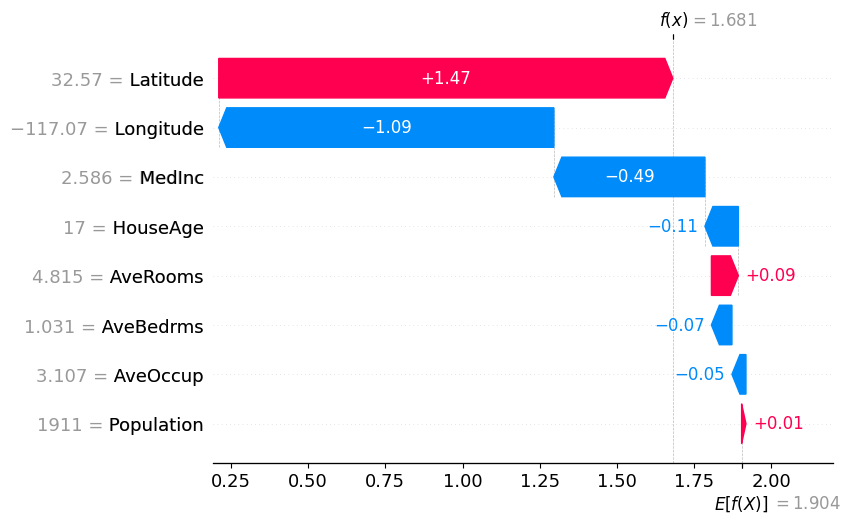

In [14]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

#### 4.1 show info
- **Shapley values**: in the waterfall_plot, the shapley values are showed in the barplot. Positive shapley values are plot in red bar and negative shap values are ploted in blue
  
- **Data**: in the waterfall_plot, the data, the value of each feature are showed in the left size

In [21]:
# show shap values
shap_values[sample_ind].values

array([-0.48900816, -0.10840999,  0.08734303, -0.06647713,  0.01402258,
       -0.04536997,  1.47024547, -1.08511549])

In [23]:
# show the data
shap_values[sample_ind].data

array([ 2.58590000e+00,  1.70000000e+01,  4.81463415e+00,  1.03089431e+00,
        1.91100000e+03,  3.10731707e+00,  3.25700000e+01, -1.17070000e+02])

#### 4.2 Calculate the prediction since base_value + shapley values 
The prediction of the model is the sum the shapley values of all features plus the base value

y_pred = base_value(shapley_value) + sum(shapley values)


- **base_value**: it is showed in the waterfall plot as the expected value **E(F(x))**

- **prediction**: the prediction of the model is showed inh the waterfall plot as **F(x)**

In [26]:
# the sum of shapley values
shapley_values_instance_sum = shap_values[sample_ind].values.sum()
shapley_values_instance_sum

-0.2227696588157933

In [27]:
# the base value
shapley_values_instance_base_value = shap_values[sample_ind].base_values
shapley_values_instance_base_value

1.9035338119654202

In [30]:
# calculate prediction from shapley values
shapley_values_prediction = shapley_values_instance_base_value + shapley_values_instance_sum
shapley_values_prediction

1.680764153149627

In [44]:
# calculate prediction from model.predict()
instance = X.iloc[[sample_ind], :]
lr.predict(instance)

array([1.68076415])

### 4. Waterfall plot (individual explanation)
- Plots an explanation of a single prediction as a waterfall plot.

- The SHAP value of a feature represents the impact of the evidence provided by that feature on the model’s output. The waterfall plot is designed to visually display how the SHAP values (evidence) of each feature move the model output from our prior expectation under the background data distribution, to the final model prediction given the evidence of all the features.

- https://shap.readthedocs.io/en/latest/generated/shap.plots.waterfall.html

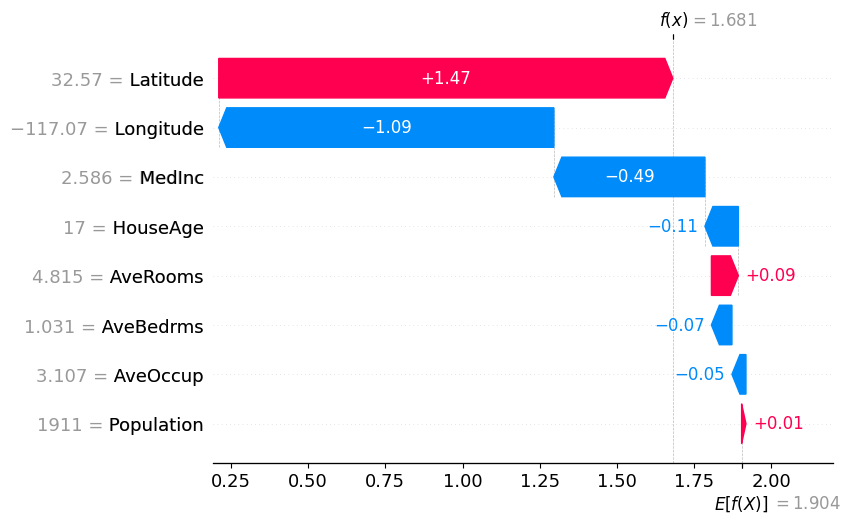

In [70]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

Spanish - explication 2

- Utiliza para visualizar la contribución de cada característica a la diferencia entre el valor esperado del modelo y el valor de predicción para una instancia de datos específica.

 - En un gráfico de cascada de SHAP, **cada barra representa la contribución de una característica específica al cambio en la predicción del modelo en comparación con la predicción promedio del modelo.** Las barras se suman para obtener la predicción final del modelo para esa instancia de datos en particular.

- Esto puede ser útil para comprender cómo cada característica influye en las predicciones del modelo para casos individuales, lo que puede ayudar a interpretar y explicar las predicciones del modelo de manera más detallada.

### 5. beeswarm plot (all observation explanation)
- 
En el contexto de SHAP (SHapley Additive exPlanations), un gráfico de enjambre de abejas puede utilizarse para visualizar la distribución de los valores de una característica específica en el conjunto de datos, con colores que indican la contribución de esa característica a la predicción del modelo para cada punto de dato

- Esto proporciona una forma intuitiva de entender cómo una característica específica afecta las predicciones del modelo en diferentes puntos del espacio de características, lo que puede ser útil para identificar patrones y relaciones en los datos.o.

**Entendimiento gráfico**
- Las feautures están ordenandas del que más impacta al que menos impacta de forma global
- Cada punto representa una observación
- El color del punto representa el valor de la observación, un color rojo representa un valor alto, mientras que un color azul representa un valor más bajo
- Si está a la izquierda tiene un shap value negativo (tiene una contribución negativa en la predicción del modelo en comparación con la predicción promedio del modelo)

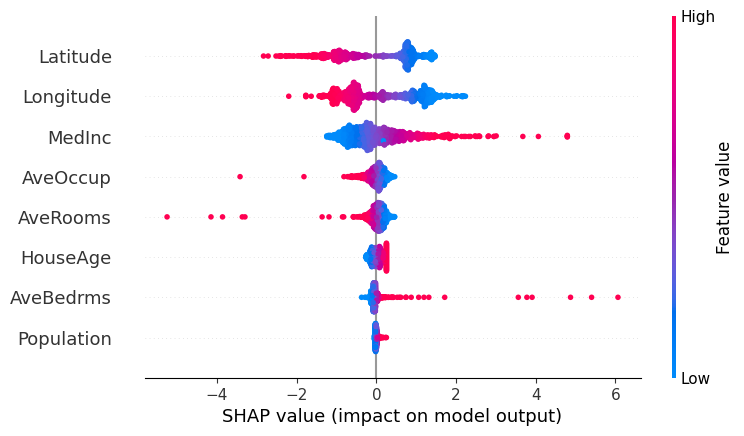

In [71]:
# beeswarm
shap.plots.beeswarm(shap_values)

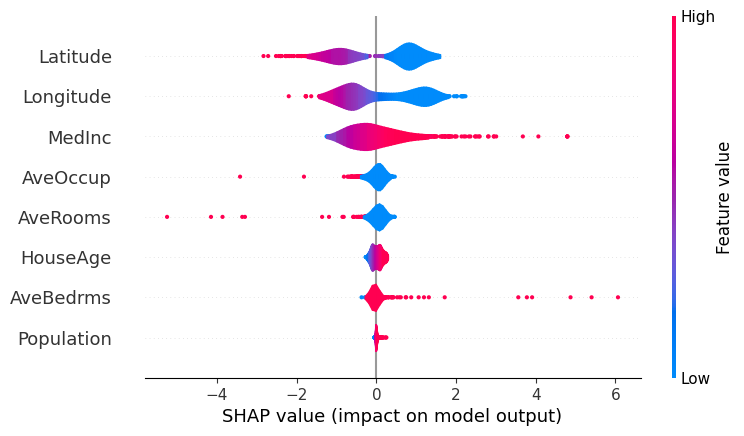

In [74]:
# beeswarm - option 2 - violin
shap.plots.violin(shap_values)

### 6. Trend of predictions with its shapley values

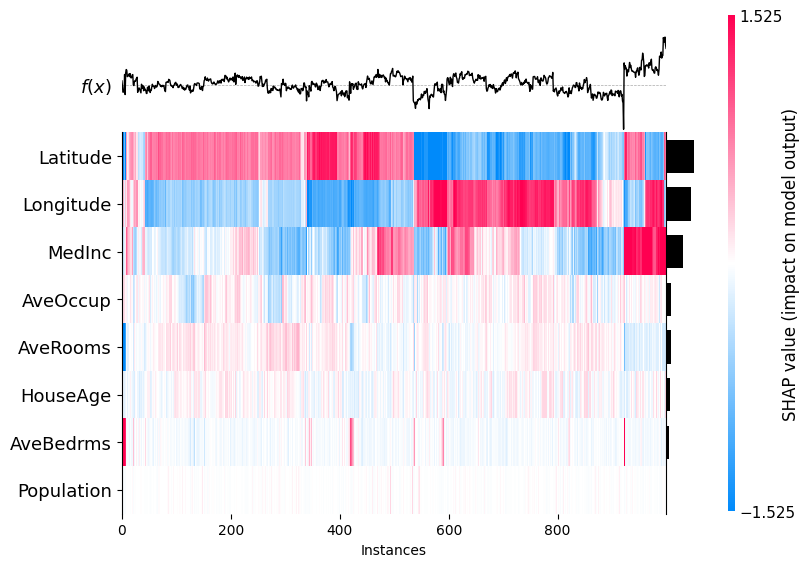

In [73]:
shap.plots.heatmap(shap_values[:1000])